# Advection-diffusion 1D
***
Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, UW
***

$\partial_t u = c^2\partial_{xx}u - \beta u_x$ 

subject to zero Dirichlet boundary conditions. Its analytical solution is given by 

\begin{align*}
u(x,t)=e^{\frac{-\beta^2 t}{4c^2}} e^{\frac{\beta x}{2c^2}} \sum_{n=1}^{\infty} b_n \sin \left(n \pi x\right) e^{-c^2\left(n \pi\right)^2 t}    
\end{align*}
where $b_n$ are found imposing the initial condition to get 
\begin{align*}
    b_n=2 \int_0^1 e^{-\frac{\beta x}{2c^2}} \left(-4\left(x-0.5\right)^{2}+1\right) \sin \left(n \pi x\right)  \mathrm{d} x
\end{align*}


## Libraries

In [1]:
import sys
sys.path.append('/Users/josorior/Documents/UW/research/kinetick/kinetick/source')

In [2]:
import jax.numpy as np
from jax import grad, jit
from jax.scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from interpolation import *
from kernels import *
from integrate import trap
from sklearn.metrics import mean_squared_error

import jax.numpy as jnp
from jax import grad, jit
from jax.config import config; 
from numpy.linalg import norm
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

## Utils

In [3]:
def Kphiphi_assembly(Xomega, Xboundary , h, b, c, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian
  if k == 'Matern1':
    kernel = Matern_Kernel_1

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,M))

  # Block 1,1 
  val1 = K(kernel, Xomega, Xomega, k_param) # K(X,X)
  val2 = K_dot(kernel, Xomega, Xomega, k_param, 0) # D1 K(X,X)
  val3 = K_dot(kernel, Xomega, Xomega, k_param, 1) # D1 K(X,X)
  #val3 = val2 # D2 K(X,X)
  val4 = K_ddot(kernel, Xomega, Xomega, k_param, 0, 0) # D1D1 K(X,X)
  val5 = K_ddot(kernel, Xomega, Xomega, k_param, 1, 1) # D1D1 K(X,X)
  #val5 = val4 # D2D2 K(X,X)
  val6 = K_ddot(kernel, Xomega, Xomega, k_param, 0, 1) # D2D1 K(X,X)
  val7 = K_dddot(kernel, Xomega, Xomega, k_param, 0, 1, 1) # D2D2 D1 K(X,X)
  val8 = K_dddot(kernel, Xomega, Xomega, k_param, 0, 0, 1) # D2 D1D1 K(X,X)
  val9 = K_ddddot(kernel, Xomega, Xomega, k_param, 0, 0, 1, 1) # D2D2 D1D1 K(X,X)
  val = val1-h*(c**2)*val4+b*h*val2 -h*(c**2)*(val5-h*(c**2)*val9+b*h*val7) +b*h*(val3-h*(c**2)*val8+b*h*val6)
  Theta = Theta.at[:Momega, :Momega].set(val)

  # Block 1,2
  val1 = K(kernel, Xomega, Xboundary, k_param)
  val4 = K_ddot(kernel, Xomega, Xboundary, k_param, 0, 0)
  val2 = K_dot(kernel, Xomega, Xboundary, k_param, 0)
  val = val1-h*(c**2)*val4+b*h*val2
  Theta = Theta.at[:Momega, Momega:].set(val)
  Theta = Theta.at[Momega:, :Momega].set(jnp.transpose(val)) # Block 2,1

  # Block 2,2
  val = K(kernel, Xboundary , Xboundary, k_param)
  Theta = Theta.at[Momega:, Momega:].set(val)

  return Theta

In [4]:
def Kphi_assembly(Xtest, Xomega, Xboundary , h, b, c, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian
  if k == 'Matern1':
    kernel = Matern_Kernel_1

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  Mtest = len(Xtest)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,Mtest))

  # Block 1
  val1 = K(kernel, Xomega, Xtest, k_param)
  val4 = K_ddot(kernel, Xomega, Xtest, k_param, 0, 0)
  val2 = K_dot(kernel, Xomega, Xtest, k_param, 0)
  val = val1-h*(c**2)*val4+b*h*val2
  Theta = Theta.at[:Momega, :].set(val)

  # Block 2
  val = K(kernel, Xboundary , Xtest, k_param)
  Theta = Theta.at[Momega:, :].set(val)


  return Theta

## How far can we go ?

In [5]:
# X_full
Xfull = np.linspace(0,1,52)
# X_{\partial\Omega}
Xboundary = Xfull[[0,-1]]
# X_\Omega
Xomega = Xfull[1:-1]
# u(X_\Omega,0)
u0 = ad_u0(Xomega)
# Advection coefficient
beta = 5
# Diffusion coefficient
c = 1
# kernel
kernel = 'Gaussian'
# Kernel lenght-scale
k_param = 0.5
# Time step
h = 0.005
# nugget
nugget = 1e-7
# number of eigenvalues in analytical solution
n = 20

Build `Kphiphi`

In [6]:
Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, c, k = kernel, k_param = k_param)

Build `y_prev`

In [7]:
y_prev = jnp.concatenate((u0,np.zeros((len(Xboundary)),)))

Compute $K(\varphi,\varphi)^{-1}y_{\text{prev}}$

In [8]:
R = jnp.diag(jnp.diag(Kphiphi))
sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)

Get `K(Xtest,Xfull)`

In [9]:
Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, c, k = kernel, k_param = k_param)

In [10]:
u_next = np.dot(Kphi.T,sol)

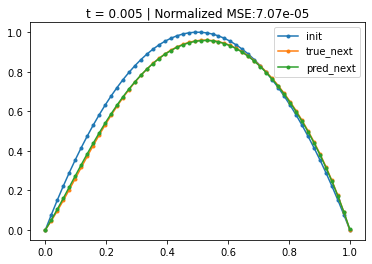

In [11]:
# Initial condition
plt.plot(Xfull,ad_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,ad_sol(Xfull,h,beta,c,n),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,ad_sol(Xfull,h,beta,c,n))/mean_squared_error(0*ad_sol(Xfull,h,beta,c,n),ad_sol(Xfull,h,beta,c,n))
plt.title('t = {} | Normalized MSE:{}'.format(h, round(nmse,7)))
plt.legend()
plt.show()

## Let's take small steps 

Say we want to get to `t=0.2` by taking `h = 0.01`

In [12]:
t = 0.15
steps = int(t//h)
# Initialize at the initial condition
uprev = u0
for _ in range(steps):
    y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
    sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
    u_next = np.dot(Kphi.T,sol)
    # update
    uprev = u_next[1:-1]

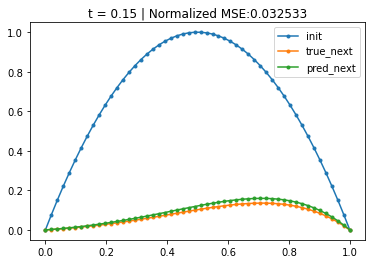

In [13]:
plt.figure()
# Initial condition
plt.plot(Xfull,ad_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,ad_sol(Xfull,t,beta,c,20),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,ad_sol(Xfull,t,beta,c,20))/mean_squared_error(0*ad_sol(Xfull,t,beta,c,20),ad_sol(Xfull,t,beta,c,20))
plt.title('t = {} | Normalized MSE:{}'.format(t, round(nmse,7)))
plt.legend()
plt.show()

## Convergence

### Experiment 1

- $h = $`1e-1`
- $t= 0.15$
- Collocation points increasing from $2^2$ to $2^{10}$

In [14]:
# Experiment 1.1 - L2-norms
L2_norms_1 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = ad_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Diffusion coefficient
    c = 1
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-1
    # Final t
    t = 0.15
    # No. of steps
    steps = int(t//h)
    # No. of eigenvalues
    n = 20
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, c, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, c, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = ad_sol(Xfull, t, beta, c, n)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_1.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.2328842014165812
0.23650753212880246
0.23652283050839307
0.23653122650680716
0.23653463173044895
0.23653650260909206
0.23653791311027955
0.23653920292859576


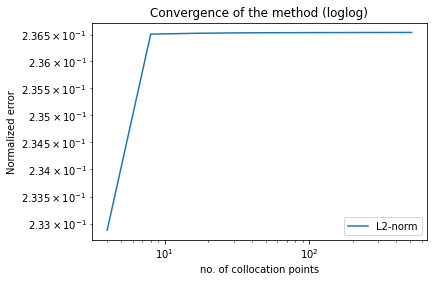

In [15]:
# Experiment 1 - Convergence plot
plt.loglog(xrange,L2_norms_1,label = 'L2-norm')
plt.xlabel('no. of collocation points')
plt.ylabel('Normalized error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

- $h = $`1e-2`
- $t= 0.15$
- Collocation points increasing from $2^2$ to $2^{10}$

In [16]:
# Experiment 1.2 - L2-norms
L2_norms_2 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = ad_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Diffusion coefficient
    c = 1
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-2
    # Final t
    t = 0.15
    # No. of steps
    steps = int(t//h)
    # No. of eigenvalues
    n = 20
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, c, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, c, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = ad_sol(Xfull, t, beta, c, n)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_2.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.02698474450900193
0.03211779760459311
0.03238406075584719
0.032403971606127596
0.032408860643735944
0.03241563074660538
0.03242595183678589
0.03244164298255223


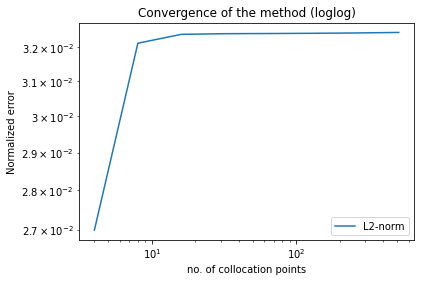

In [17]:
# Experiment 2 - Convergence plot
plt.loglog(xrange,L2_norms_2,label = 'L2-norm')
plt.xlabel('no. of collocation points')
plt.ylabel('Normalized error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

- $h = $`1e-3`
- $t= 0.15$
- Collocation points increasing from $2^2$ to $2^{10}$

In [18]:
# Experiment 1.3 - L2-norms
L2_norms_3 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = ad_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Diffusion coefficient
    c = 1
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-3
    # Final t
    t = 0.15
    # No. of steps
    steps = int(t//h)
    # No. of eigenvalues
    n = 20
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, c, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, c, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = ad_sol(Xfull, t, beta, c, n)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_3.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.0029450291912681147
0.003312144011249301
0.0030567330547605397
0.0030735109687701954
0.003145968452159256
0.0032300000336158616
0.003284873659800718
0.0032698717056083774


- $h = $`1e-4`
- $t= 0.15$
- Collocation points increasing from $2^2$ to $2^{10}$

In [19]:
# Experiment 1.4 - L2-norms
L2_norms_4 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = ad_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Diffusion coefficient
    c = 1
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-4
    # Final t
    t = 0.15
    # No. of steps
    steps = int(t//h)
    # No. of eigenvalues
    n = 20
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, c, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, c, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = ad_sol(Xfull, t, beta, c, n)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_4.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.003523554688179895
0.0004155755204340548
0.0003672148872822993
0.0003448332453707684
0.00031138910714609925
0.0002949146096712549
0.0003186373987759731
0.0004090492736802884


- $h = $`1e-5`
- $t= 0.15$
- Collocation points increasing from $2^2$ to $2^{10}$

In [20]:
# Experiment 1.5 - L2-norms
L2_norms_5 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = ad_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Diffusion coefficient
    c = 1
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-5
    # Final t
    t = 0.15
    # No. of steps
    steps = int(t//h)
    # No. of eigenvalues
    n = 20
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, c, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, c, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = ad_sol(Xfull, t, beta, c, n)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_5.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.003165307376084139
0.001113877094717351
0.0007178725925045867
0.0005170273808408616
0.00036911328427728494
0.0002509220473532543
0.00017116934258587792
0.00012347442902544548


Text(0.5, 1.0, '$h = 1e-5$')

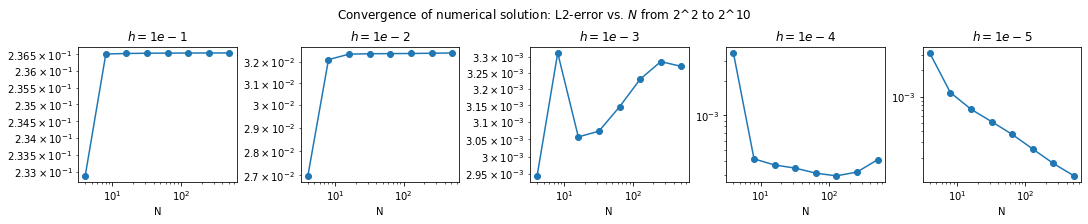

In [21]:
# Different plots
fig, axs = plt.subplots(nrows = 1, ncols=5 , figsize = (15,3),constrained_layout=True)
fig.suptitle('Convergence of numerical solution: L2-error vs. $N$ from 2^2 to 2^10')
axs[0].loglog(xrange, L2_norms_1, marker = 'o')
axs[0].set_xlabel('N')
axs[0].set_title('$h = 1e-1$')
axs[1].loglog(xrange, L2_norms_2, marker = 'o')
axs[1].set_xlabel('N')
axs[1].set_title('$h = 1e-2$')
axs[2].loglog(xrange, L2_norms_3, marker = 'o')
axs[2].set_xlabel('N')
axs[2].set_title('$h = 1e-3$')
axs[3].loglog(xrange, L2_norms_4, marker = 'o')
axs[3].set_xlabel('N')
axs[3].set_title('$h = 1e-4$')
axs[4].loglog(xrange, L2_norms_5, marker = 'o')
axs[4].set_xlabel('N')
axs[4].set_title('$h = 1e-5$')

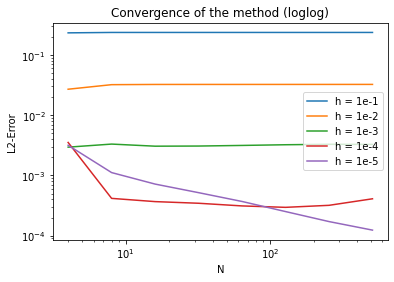

In [22]:
# One plot
plt.loglog(xrange,L2_norms_1,label = 'h = 1e-1')
plt.loglog(xrange,L2_norms_2,label = 'h = 1e-2')
plt.loglog(xrange,L2_norms_3,label = 'h = 1e-3')
plt.loglog(xrange,L2_norms_4,label = 'h = 1e-4')
plt.loglog(xrange,L2_norms_5,label = 'h = 1e-5')
plt.xlabel('N')
plt.ylabel('L2-Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

### Experiment 2

- $h$ decreasing from `1e-2` to `1e-5`
- $t= 0.15$
- Collocation points = $2^5$

In [23]:
# Experiment 2.1 - L2-norms
L2_norms_1 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(0,1,2**5+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = ad_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Diffusion coefficient
    c = 1
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    t = 0.15
    # No. of steps
    steps = int(t//h)
    # No. of eigenvalues
    n = 20
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, c, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, c, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = ad_sol(Xfull, t, beta, c, n)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_1.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.032403971606127596
0.0030735109687701954
0.0003448332453707684
0.0005170273808408616


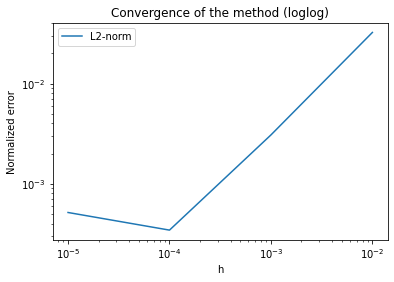

In [24]:
# Experiment 2.1 - Convergence plot
plt.loglog(xrange,L2_norms_1,label = 'L2-norm')
plt.xlabel('h')
plt.ylabel('Normalized error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

- $h$ decreasing from `1e-2` to `1e-5`
- $t= 0.15$
- Collocation points = $2^6$

In [25]:
# Experiment 2.2 - L2-norms
L2_norms_2 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(0,1,2**6+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = ad_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Diffusion coefficient
    c = 1
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    t = 0.15
    # No. of steps
    steps = int(t//h)
    # No. of eigenvalues
    n = 20
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, c, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, c, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = ad_sol(Xfull, t, beta, c, n)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_2.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.032408860643735944
0.003145968452159256
0.00031138910714609925
0.00036911328427728494


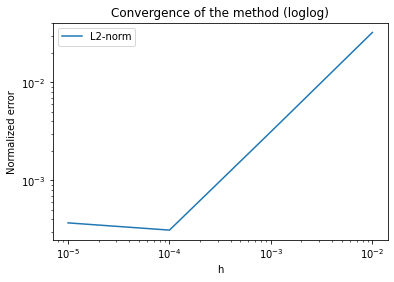

In [26]:
# Experiment 2.2 - Convergence plot
plt.loglog(xrange,L2_norms_2,label = 'L2-norm')
plt.xlabel('h')
plt.ylabel('Normalized error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

- $h$ decreasing from `1e-2` to `1e-5`
- $t= 0.15$
- Collocation points = $2^7$

In [27]:
# Experiment 2.3 - L2-norms
L2_norms_3 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(0,1,2**7+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = ad_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Diffusion coefficient
    c = 1
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    t = 0.15
    # No. of steps
    steps = int(t//h)
    # No. of eigenvalues
    n = 20
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, c, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, c, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = ad_sol(Xfull, t, beta, c, n)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_3.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.03241563074660538
0.0032300000336158616
0.0002949146096712549
0.0002509220473532543


- $h$ decreasing from `1e-2` to `1e-5`
- $t= 0.15$
- Collocation points = $2^8$

In [28]:
# Experiment 2.4 - L2-norms
L2_norms_4 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(0,1,2**8+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = ad_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Diffusion coefficient
    c = 1
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    t = 0.15
    # No. of steps
    steps = int(t//h)
    # No. of eigenvalues
    n = 20
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, c, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, c, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = ad_sol(Xfull, t, beta, c, n)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_4.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.03242595183678589
0.003284873659800718
0.0003186373987759731
0.00017116934258587792


- $h$ decreasing from `1e-2` to `1e-5`
- $t= 0.15$
- Collocation points = $2^9$

In [29]:
# Experiment 2.5 - L2-norms
L2_norms_5 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(0,1,2**9+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = ad_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Diffusion coefficient
    c = 1
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    t = 0.15
    # No. of steps
    steps = int(t//h)
    # No. of eigenvalues
    n = 20
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, c, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, c, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = ad_sol(Xfull, t, beta, c, n)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_5.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.03244164298255223
0.0032698717056083774
0.0004090492736802884
0.00012347442902544548


Text(0.5, 1.0, '$N = 2^9$')

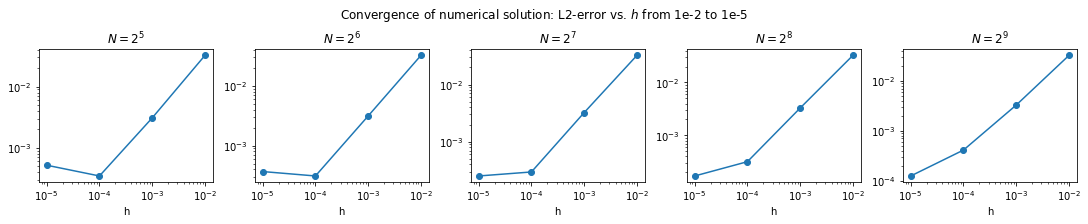

In [30]:
# Different plots
fig, axs = plt.subplots(nrows = 1, ncols=5 , figsize = (15,3),constrained_layout=True)
fig.suptitle('Convergence of numerical solution: L2-error vs. $h$ from 1e-2 to 1e-5')
axs[0].loglog(xrange, L2_norms_1, marker = 'o')
axs[0].set_xlabel('h')
axs[0].set_title('$N = 2^5$')
axs[1].loglog(xrange, L2_norms_2, marker = 'o')
axs[1].set_xlabel('h')
axs[1].set_title('$N = 2^6$')
axs[2].loglog(xrange, L2_norms_3, marker = 'o')
axs[2].set_xlabel('h')
axs[2].set_title('$N = 2^7$')
axs[3].loglog(xrange, L2_norms_4, marker = 'o')
axs[3].set_xlabel('h')
axs[3].set_title('$N = 2^8$')
axs[4].loglog(xrange, L2_norms_5, marker = 'o')
axs[4].set_xlabel('h')
axs[4].set_title('$N = 2^9$')

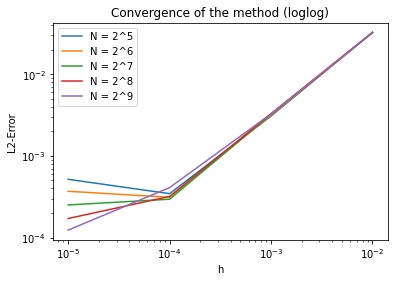

In [31]:
# One plot
plt.loglog(xrange,L2_norms_1,label = 'N = 2^5')
plt.loglog(xrange,L2_norms_2,label = 'N = 2^6')
plt.loglog(xrange,L2_norms_3,label = 'N = 2^7')
plt.loglog(xrange,L2_norms_4,label = 'N = 2^8')
plt.loglog(xrange,L2_norms_5,label = 'N = 2^9')
plt.xlabel('h')
plt.ylabel('L2-Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()